# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [3]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

C:\Users\User\AppData\Local\Temp\ipykernel_18988\2810386256.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
C:\Users\User\AppData\Local\Temp\ipykernel_18988\2810386256.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_flat = test_X.reshape(test_X.shape[

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [4]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [5]:
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [6]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for layer_0-param_W
Gradient check passed!
Checking gradient for layer_0-param_B
Gradient check passed!
Checking gradient for layer_2-param_W
Gradient check passed!
Checking gradient for layer_2-param_B
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [7]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for layer_0-param_W
Gradient check passed!
Checking gradient for layer_0-param_B
Gradient check passed!
Checking gradient for layer_2-param_W
Gradient check passed!
Checking gradient for layer_2-param_B
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [8]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.1

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [9]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 0.001)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-1)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Loss: 1.9814635308484831, Train accuracy: 0.2281111111111111, val accuracy: 0.251
Loss: 1.801772606745695, Train accuracy: 0.4102222222222222, val accuracy: 0.423
Loss: 1.284124797746332, Train accuracy: 0.5153333333333333, val accuracy: 0.524
Loss: 1.3426807652834627, Train accuracy: 0.601, val accuracy: 0.577
Loss: 1.2606552069999473, Train accuracy: 0.6642222222222223, val accuracy: 0.636
Loss: 0.7700744253278117, Train accuracy: 0.706, val accuracy: 0.671
Loss: 0.9568784231560628, Train accuracy: 0.693, val accuracy: 0.673
Loss: 0.8396282038013484, Train accuracy: 0.7176666666666667, val accuracy: 0.675
Loss: 1.291717965261554, Train accuracy: 0.7191111111111111, val accuracy: 0.682
Loss: 0.939299126695746, Train accuracy: 0.7138888888888889, val accuracy: 0.679
Loss: 1.4469086263182596, Train accuracy: 0.7572222222222222, val accuracy: 0.709
Loss: 1.1240427567234075, Train accuracy: 0.7543333333333333, val accuracy: 0.721
Loss: 1.0354673874731795, Train accuracy: 0.766333333333333

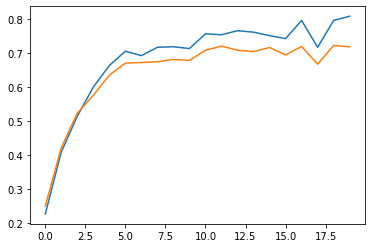

In [10]:
plt.plot(train_history)
plt.plot(val_history)

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [11]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 0.001)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-1, learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Loss: 2.1565279193147395, Train accuracy: 0.2361111111111111, val accuracy: 0.25
Loss: 2.0769231141807842, Train accuracy: 0.42477777777777775, val accuracy: 0.419
Loss: 1.7563064310547212, Train accuracy: 0.5245555555555556, val accuracy: 0.531
Loss: 1.0389262016426584, Train accuracy: 0.6245555555555555, val accuracy: 0.618
Loss: 1.3630262315892567, Train accuracy: 0.6703333333333333, val accuracy: 0.644
Loss: 1.8489081818523507, Train accuracy: 0.6845555555555556, val accuracy: 0.668
Loss: 1.1389321558205816, Train accuracy: 0.7155555555555555, val accuracy: 0.706
Loss: 1.256858423800921, Train accuracy: 0.7181111111111111, val accuracy: 0.679
Loss: 1.7418268816607143, Train accuracy: 0.7386666666666667, val accuracy: 0.691
Loss: 0.9884635205839502, Train accuracy: 0.7495555555555555, val accuracy: 0.705
Loss: 0.912017965580608, Train accuracy: 0.7417777777777778, val accuracy: 0.7
Loss: 0.7263978688672693, Train accuracy: 0.7578888888888888, val accuracy: 0.712
Loss: 1.607667225149

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [12]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 0.001)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-3, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Loss: 2.252894232746485, Train accuracy: 0.19666666666666666, val accuracy: 0.206
Loss: 2.1979636869281958, Train accuracy: 0.19666666666666666, val accuracy: 0.206
Loss: 2.3152937427197036, Train accuracy: 0.19666666666666666, val accuracy: 0.206
Loss: 2.0044765100979554, Train accuracy: 0.19666666666666666, val accuracy: 0.206
Loss: 2.0909211138267443, Train accuracy: 0.19666666666666666, val accuracy: 0.206
Loss: 2.321708451206194, Train accuracy: 0.19666666666666666, val accuracy: 0.206
Loss: 2.0960804157082986, Train accuracy: 0.19666666666666666, val accuracy: 0.206
Loss: 2.174661998490569, Train accuracy: 0.19666666666666666, val accuracy: 0.206
Loss: 2.104532828015252, Train accuracy: 0.19833333333333333, val accuracy: 0.209
Loss: 2.1243251738954387, Train accuracy: 0.2228888888888889, val accuracy: 0.226
Loss: 2.0453114606089713, Train accuracy: 0.25166666666666665, val accuracy: 0.256
Loss: 2.103845773078291, Train accuracy: 0.2617777777777778, val accuracy: 0.261
Loss: 1.813

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [13]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-2)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Loss: 2.326206818200539, Train accuracy: 0.3333333333333333, val accuracy: 0.0
Loss: 2.29631063563037, Train accuracy: 0.2, val accuracy: 0.13333333333333333
Loss: 2.2720284184521975, Train accuracy: 0.2, val accuracy: 0.13333333333333333
Loss: 2.324880494085443, Train accuracy: 0.2, val accuracy: 0.13333333333333333
Loss: 2.2865367180335805, Train accuracy: 0.2, val accuracy: 0.06666666666666667
Loss: 2.303685591526646, Train accuracy: 0.2, val accuracy: 0.06666666666666667
Loss: 2.2105651947660148, Train accuracy: 0.26666666666666666, val accuracy: 0.06666666666666667
Loss: 2.1175073003982203, Train accuracy: 0.4, val accuracy: 0.0
Loss: 1.9995371957291996, Train accuracy: 0.4, val accuracy: 0.0
Loss: 1.778502621499459, Train accuracy: 0.4, val accuracy: 0.0
Loss: 1.660829614944799, Train accuracy: 0.4, val accuracy: 0.0
Loss: 2.0237484460804525, Train accuracy: 0.4, val accuracy: 0.0
Loss: 1.4626405852246045, Train accuracy: 0.4, val accuracy: 0.0
Loss: 2.065327576485454, Train accu

Loss: 0.22907423075525812, Train accuracy: 1.0, val accuracy: 0.0
Loss: 0.2244105782006341, Train accuracy: 1.0, val accuracy: 0.0
Loss: 0.23379583801372167, Train accuracy: 1.0, val accuracy: 0.0
Loss: 0.2279164035135625, Train accuracy: 1.0, val accuracy: 0.0
Loss: 0.23922239153591546, Train accuracy: 1.0, val accuracy: 0.0
Loss: 0.23945323072968483, Train accuracy: 1.0, val accuracy: 0.0
Loss: 0.2182046652383408, Train accuracy: 1.0, val accuracy: 0.0
Loss: 0.24064632609077677, Train accuracy: 1.0, val accuracy: 0.0
Loss: 0.20906246201386702, Train accuracy: 1.0, val accuracy: 0.0
Loss: 0.23636796498030754, Train accuracy: 1.0, val accuracy: 0.0
Loss: 0.21918127055125525, Train accuracy: 1.0, val accuracy: 0.0
Loss: 0.21200269331870203, Train accuracy: 1.0, val accuracy: 0.0
Loss: 0.21383307558715287, Train accuracy: 1.0, val accuracy: 0.0
Loss: 0.2058996204251139, Train accuracy: 1.0, val accuracy: 0.0
Loss: 0.2023605017396565, Train accuracy: 1.0, val accuracy: 0.0
Loss: 0.2416569

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [14]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-2)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, SGD(), learning_rate=0.3, num_epochs=20, batch_size=5)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.3061982682356623, Train accuracy: 0.2, val accuracy: 0.13333333333333333
Loss: 2.279207978572889, Train accuracy: 0.2, val accuracy: 0.06666666666666667
Loss: 2.150635274150046, Train accuracy: 0.4, val accuracy: 0.0
Loss: 2.2380632953116755, Train accuracy: 0.4, val accuracy: 0.0
Loss: 2.2914123246385096, Train accuracy: 0.3333333333333333, val accuracy: 0.06666666666666667
Loss: 2.0674230192722476, Train accuracy: 0.4, val accuracy: 0.0
Loss: 1.6396835257980102, Train accuracy: 0.4, val accuracy: 0.0
Loss: 1.5537047416078944, Train accuracy: 0.4666666666666667, val accuracy: 0.13333333333333333
Loss: 1.8294812869022208, Train accuracy: 0.3333333333333333, val accuracy: 0.0
Loss: 1.9491447987632897, Train accuracy: 0.4, val accuracy: 0.06666666666666667
Loss: 2.025706347758715, Train accuracy: 0.6, val accuracy: 0.0
Loss: 1.2484960027414984, Train accuracy: 0.6, val accuracy: 0.0
Loss: 1.2399355704453257, Train accuracy: 0.6, val accuracy: 0.0
Loss: 0.8962765463391493, Train a

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [15]:
# Let's train the best one-hidden-layer network we can

learning_rates = 1e-1
reg_strength = 1e-3
learning_rate_decay = 0.99
hidden_layer_size = 100
num_epochs = 200
batch_size = 64

best_classifier = None
best_val_accuracy = None

loss_history = []
train_history = []
val_history = []

best_classifier = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = hidden_layer_size, 
                              reg = reg_strength)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(best_classifier, dataset, MomentumSGD(), learning_rate=learning_rates, num_epochs=num_epochs, 
                  batch_size=batch_size)
loss_history, train_history, val_history = trainer.fit()
best_val_accuracy = val_history[-1]

print('best validation accuracy achieved: %f' % best_val_accuracy)

Loss: 1.9311947783175234, Train accuracy: 0.3471111111111111, val accuracy: 0.353
Loss: 2.011920517488697, Train accuracy: 0.5353333333333333, val accuracy: 0.513
Loss: 1.6752370083089563, Train accuracy: 0.6102222222222222, val accuracy: 0.595
Loss: 1.9242394876848588, Train accuracy: 0.5726666666666667, val accuracy: 0.545
Loss: 1.6105578060707504, Train accuracy: 0.6058888888888889, val accuracy: 0.59
Loss: 1.7523265167238582, Train accuracy: 0.5946666666666667, val accuracy: 0.573
Loss: 1.98860366620159, Train accuracy: 0.6367777777777778, val accuracy: 0.607
Loss: 1.6298760679465256, Train accuracy: 0.6216666666666667, val accuracy: 0.589
Loss: 1.812504763539223, Train accuracy: 0.6626666666666666, val accuracy: 0.624
Loss: 1.6022560655911773, Train accuracy: 0.6545555555555556, val accuracy: 0.618
Loss: 1.8563973052133473, Train accuracy: 0.6502222222222223, val accuracy: 0.612
Loss: 1.2119031152486335, Train accuracy: 0.6287777777777778, val accuracy: 0.604
Loss: 2.3545309682621

Loss: 1.5408208389003004, Train accuracy: 0.6545555555555556, val accuracy: 0.629
Loss: 1.5031708116050342, Train accuracy: 0.6625555555555556, val accuracy: 0.623
Loss: 1.2999768883376184, Train accuracy: 0.6511111111111111, val accuracy: 0.627
Loss: 1.3579787471307048, Train accuracy: 0.6935555555555556, val accuracy: 0.651
Loss: 1.4214843665368324, Train accuracy: 0.6607777777777778, val accuracy: 0.629
Loss: 1.694937213410026, Train accuracy: 0.6771111111111111, val accuracy: 0.648
Loss: 1.8234131421414266, Train accuracy: 0.7103333333333334, val accuracy: 0.654
Loss: 1.5336879423911791, Train accuracy: 0.6127777777777778, val accuracy: 0.611
Loss: 1.1911095180176567, Train accuracy: 0.6831111111111111, val accuracy: 0.626
Loss: 1.7879743131739039, Train accuracy: 0.6962222222222222, val accuracy: 0.672
Loss: 2.1290371082988675, Train accuracy: 0.629, val accuracy: 0.586
Loss: 1.6902802090540234, Train accuracy: 0.6447777777777778, val accuracy: 0.605
Loss: 1.4796915428345532, Trai

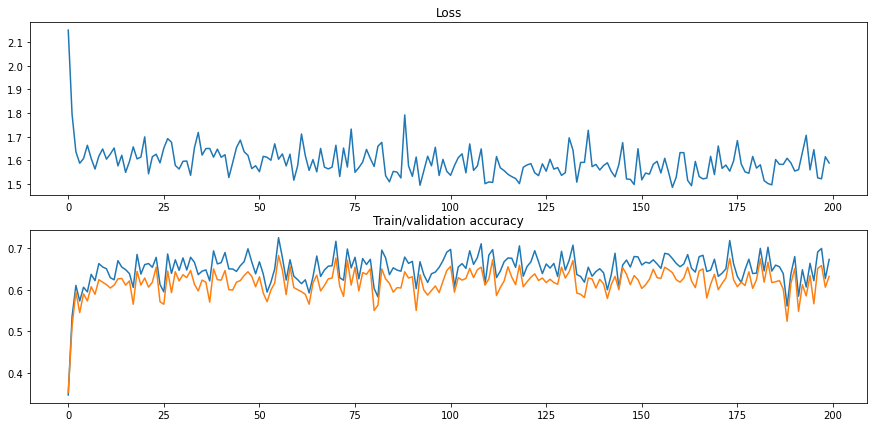

In [16]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [17]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.578000
